In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import aif360
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('adult.csv')
del df['education']
df.head()

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


De categorische variabelen binair maken 

In [3]:
df['income'] = (df['income']=='<=50K').astype(int)
df['race'] = np.where(df['race'].str.contains('White'),1,0)
df['sex'] = np.where(df['sex'].str.contains('Female'),1,0)

Aangeven welke factoren waarvoor bedoeld zijn (label/verwachte bias/categorisch/continue)

In [4]:
expected_bias = ['sex']
target = ['income']
cat = ['workclass','marital.status','occupation','relationship',
       'native.country']
continuous = ['age','fnlwgt','education.num','capital.gain',
              'capital.loss','hours.per.week']

Dummy variabelen maken van de categorische variabelen

In [5]:
dum = pd.get_dummies(df[cat].astype('category'),prefix_sep='=')
encoded_df = pd.concat([dum, df[continuous], df[expected_bias], 
                        df[target]], axis=1)

De privileged en unprivileged groups aangeven

In [6]:
privileged_groups = [{'sex':0}]
unprivileged_groups = [{'sex':1}]
favorable_label = 0
unfavorable_label = 1

Een Binary Label Dataset maken van de dataframe (nodig voor AI Fairness 360)

In [7]:
aif360_dataset = aif360.datasets.BinaryLabelDataset(
    favorable_label=favorable_label,
    unfavorable_label=unfavorable_label,
    df=encoded_df,
    label_names=['income'],
    protected_attribute_names=['sex'])

Een test en training set aanmaken

In [8]:
aif360_train, aif360_test = aif360_dataset.split([0.7],shuffle=False)

De metrics bepalen voor de originele dataset

In [9]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(aif360_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Original training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.statistical_parity_difference())

Original training dataset
Difference in mean outcomes between unprivileged and privileged groups = -0.207608


In [10]:
spd_before = round(metric_orig_train.statistical_parity_difference(),4)
di_before = round(metric_orig_train.disparate_impact(),4)

(-0.2076, 0.3687)

In [28]:
print("Statistical Parity Difference dataset: {}".format(spd_before))
print("Disparate Impact dataset: {}".format(di_before))

Statistical Parity Difference dataset: -0.2076
Disparate Impact dataset: 0.3687


### Make classifier predictions

Voorspellingen maken met de dataset door middel van AdaBoosting

In [11]:
cls = AdaBoostClassifier(n_estimators=100)
cls.fit(aif360_dataset.features, aif360_dataset.labels,sample_weight=aif360_dataset.instance_weights)
print("Accuracy:", metrics.accuracy_score(aif360_test.labels,
                                          cls.predict(aif360_test.features)))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Accuracy: 0.8605793837649708


In [12]:
yhat = cls.predict(aif360_test.features)

### Reweighing

De dataset reweighen om de aantallen gelijk te krijgen en de bias eruit te halen

In [13]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(aif360_train)
transf_dataset = RW.transform(aif360_train)

Een test en training set aanmaken

In [14]:
aif360_train_after, aif360_test_after = transf_dataset.split([0.7])

De metrics bepalen voor de nieuwe dataset

In [15]:
# Metric for the transformed dataset
metric_orig_train_after = BinaryLabelDatasetMetric(aif360_train_after, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Transformed training dataset")
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train_after.statistical_parity_difference())

Transformed training dataset
Difference in mean outcomes between unprivileged and privileged groups = 0.003784


In [16]:
spd_after = round(metric_orig_train_after.statistical_parity_difference(),4)
di_after = round(metric_orig_train_after.disparate_impact(),4)

In [27]:
print("Statistical Parity Difference nieuwe dataset: {}".format(spd_after))
print("Disparate Impact nieuwe dataset: {}".format(di_after))

Statistical Parity Difference nieuwe dataset: 0.0038
Disparate Impact nieuwe dataset: 1.013


### Make classifier predictions after reweighing

Voorspellingen maken met de nieuwe dataset door middel van AdaBoosting

In [18]:
cls = AdaBoostClassifier(n_estimators=100)
model = cls.fit(transf_dataset.features, transf_dataset.labels,sample_weight=transf_dataset.instance_weights)
print("Accuracy:", metrics.accuracy_score(transf_dataset.labels,
                                          model.predict(transf_dataset.features)))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Accuracy: 0.8667076167076168


In [19]:
yhat_after = model.predict(aif360_test_after.features)

## Visualisaties

### Statistical Parity Difference

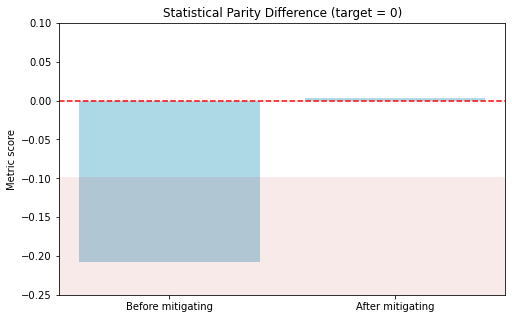

In [20]:
plt.figure(figsize=(8,5))
names = ['Before mitigating','After mitigating']
values = [spd_before,spd_after]
plt.axhline(y=-0.2,color='#CD3333',linewidth=158,alpha=0.1)
plt.bar(names,values,color='#ADD8E6',alpha=1)
plt.title('Statistical Parity Difference (target = 0)')
plt.axhline(y=0,c='r',linestyle='dashed')
plt.ylim(-0.25,0.1)
plt.ylabel('Metric score')
plt.show()

### Disparate Impact

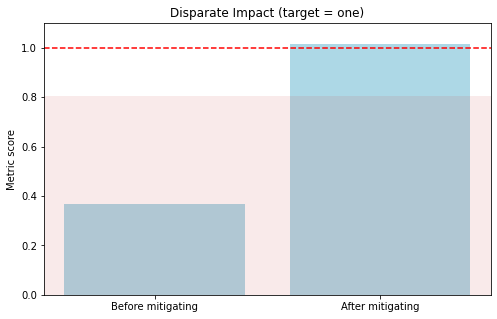

In [24]:
plt.figure(figsize=(8,5))
names = ['Before mitigating','After mitigating']
values = [di_before,di_after]
plt.axhline(y=0.3,color='#CD3333',linewidth=250,alpha=0.1)
plt.bar(names,values,color='#ADD8E6')
plt.title('Disparate Impact (target = one)')
plt.axhline(y=1,c='r',linestyle='dashed')
plt.ylim(0,1.1)
plt.ylabel('Metric score')
plt.show()